In [ ]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import chi2
from scipy.special import erfinv, erfcinv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import numpy as np

import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../..')))
from tensiometer import utilities

def estimate_centroid_and_covariance(means, covariances):
    means = np.array(means)
    covariances = np.array(covariances)
    
    # Calculate the inverse of each covariance matrix
    inv_covariances = np.linalg.inv(covariances)
    
    # Calculate the weighted sum of the means
    weighted_means = np.einsum('ijk,ik->ij', inv_covariances, means)
    sum_inv_covariances = np.sum(inv_covariances, axis=0)
    
    # Calculate the centroid
    centroid = np.linalg.solve(sum_inv_covariances, np.sum(weighted_means, axis=0))
    
    # Calculate the covariance of the centroid
    centroid_covariance = np.linalg.inv(sum_inv_covariances)
    
    return centroid, centroid_covariance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Three moltivariate distributions

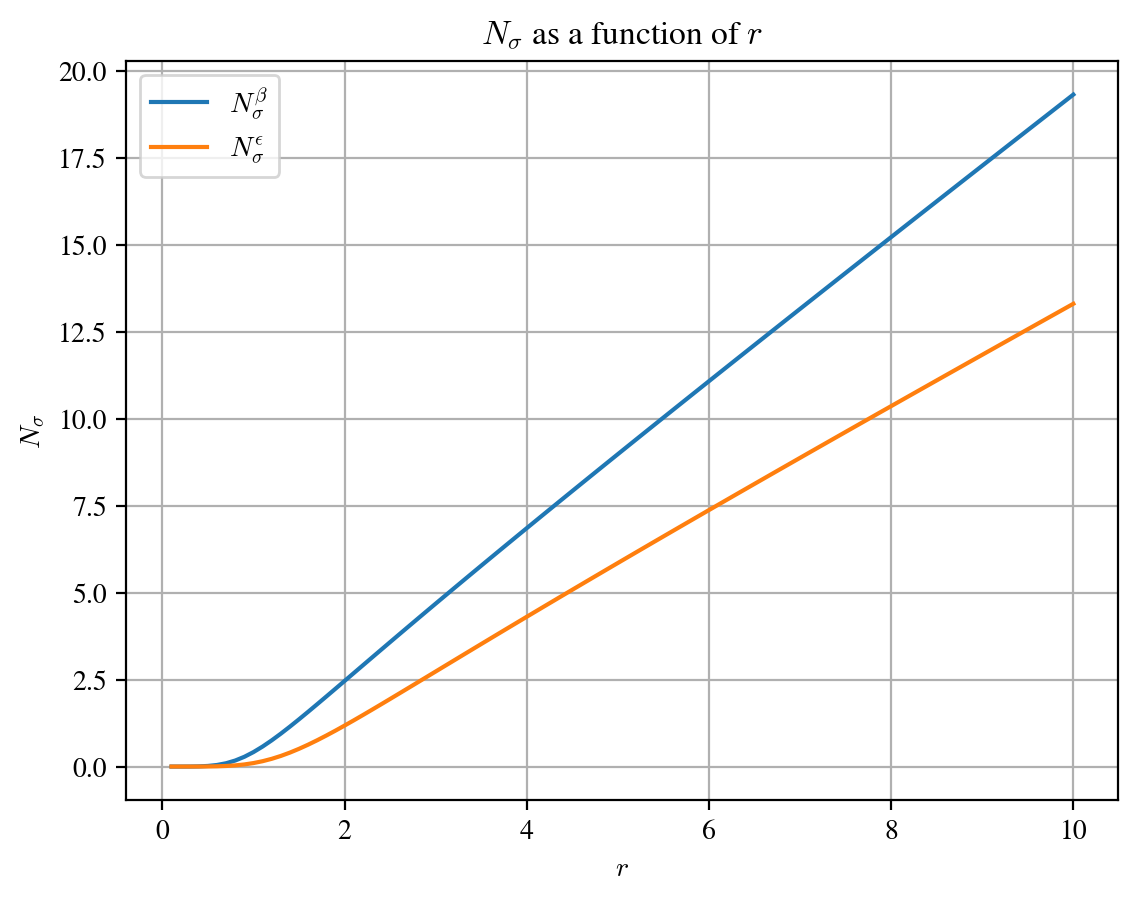

In [8]:
r = 1
def n_sigmas(r):
        #Fixed Parameters
        num_parameters = 2
        num_datasets = 3
        theta_A = 0
        theta_B = np.pi/2
        theta_C = np.pi

        #Sharp triangle
        mean_A = r*np.array([np.cos(theta_A), np.sin(theta_A)]) 
        mean_B = r*np.array([np.cos(theta_B), np.sin(theta_B)]) 
        mean_C = r*np.array([np.cos(theta_C), np.sin(theta_C)]) 

        cov_A = np.array([[1, 0.], [0., 1]])
        cov_B = cov_A.copy()
        cov_C = cov_A.copy()

        samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
        samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
        samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

        names = ['x', 'y']
        labels = ['x', 'y']

        chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
        chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
        chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

        cov_tot = cov_A + cov_B + cov_C

        centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C], [cov_A, cov_B, cov_C])
        mean_bar = centroid
        cov_bar = centroid_covariance

        delta_theta_A = mean_A - mean_bar
        delta_theta_B = mean_B - mean_bar
        delta_theta_C = mean_C - mean_bar

        samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
        chain_bar = MCSamples(samples=samps_bar, names=names, labels=labels, label='Bar')

        beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
        + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
        + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))
        df=num_datasets*num_parameters
        PTE = chi2.sf(beta, df)
        #n_sigma_beta = utilities.from_confidence_to_sigma(1-PTE)
        n_sigma_beta = np.sqrt(2)*erfcinv(PTE)
        #print('n^b_sigma: {:5g}'.format(n_sigma_beta))


        epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
                + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
                + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))
        df=num_datasets*num_parameters
        PTE = chi2.sf(epsilon, df)
        #n_sigma_epsilon = utilities.from_confidence_to_sigma(1-PTE)
        n_sigma_epsilon = np.sqrt(2)*erfcinv(PTE)
        #print('n^s_sigma: {:5g}'.format(n_sigma_epsilon))
        return n_sigma_beta, n_sigma_epsilon

n_sigma_beta, n_sigma_epsilon = n_sigmas(r)

r_values = np.linspace(0.1, 10, 100)
plt.plot(r_values, [n_sigmas(r)[0] for r in r_values], label=r'$N^{\beta}_\sigma$')
plt.plot(r_values, [n_sigmas(r)[1] for r in r_values], label=r'$N^{\epsilon}_\sigma$')
plt.legend()
plt.xlabel(r'$r$')
plt.ylabel(r'$N_\sigma$')
plt.grid()
plt.title(r'$N_\sigma$ as a function of $r$')
plt.show()

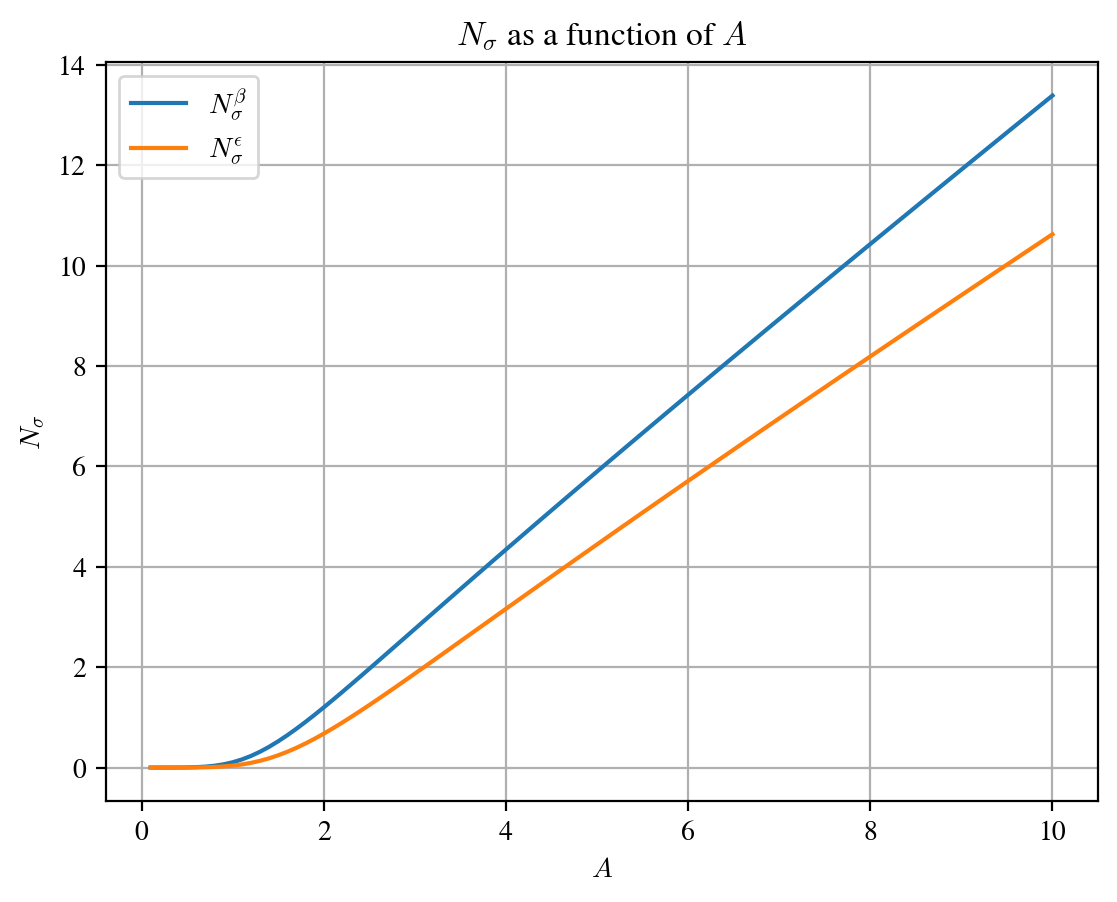

In [6]:

def n_sigmas(r):
    #Fixed Parameters
    num_parameters = 2
    num_datasets = 3

    #Sharp triangle
    theta_A = 0
    theta_B = np.pi
    theta_C = np.pi/2


    #Sharp triangle
    mean_A = r*np.array([np.cos(theta_A), np.sin(theta_A)]) 
    mean_B = r*np.array([np.cos(theta_B), np.sin(theta_B)]) 
    mean_C = np.array([np.cos(theta_C), np.sin(theta_C)]) 

    cov_A = np.array([[1, 0.], [0., 1]])
    cov_B = cov_A.copy()
    cov_C = 100*cov_A.copy()

    samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
    samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
    samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

    names = ['x', 'y']
    labels = ['x', 'y']

    chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
    chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

    cov_tot = cov_A + cov_B + cov_C

    centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C], [cov_A, cov_B, cov_C])
    mean_bar = centroid
    cov_bar = centroid_covariance

    delta_theta_A = mean_A - mean_bar
    delta_theta_B = mean_B - mean_bar
    delta_theta_C = mean_C - mean_bar

    samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
    chain_bar = MCSamples(samples=samps_bar, names=names, labels=labels, label='Bar')

    beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
    + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
    + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))
    df=num_datasets*num_parameters
    PTE = chi2.sf(beta, df)
    n_sigma_beta = np.sqrt(2)*erfcinv(PTE)
    #n_sigma_beta = utilities.from_confidence_to_sigma(1-PTE)
    #print('n^b_sigma: {:5g}'.format(n_sigma_beta))


    epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
            + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
            + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))
    df=num_datasets*num_parameters
    PTE = chi2.sf(epsilon, df)
    
    #n_sigma = np.sqrt(2)*erfcinv(PTE)
    #print(n_sigma)
    #print('n_sigma: {:5g}'.format(n_sigma))

    n_sigma_epsilon = np.sqrt(2)*erfcinv(PTE)
    #n_sigma_epsilon = utilities.from_confidence_to_sigma(1-PTE)
    #print('n^s_sigma: {:5g}'.format(n_sigma_epsilon))
    return n_sigma_beta, n_sigma_epsilon

r_values = np.linspace(0.1, 10, 100)
plt.plot(r_values, [n_sigmas(r)[0] for r in r_values], label=r'$N^{\beta}_\sigma$')
plt.plot(r_values, [n_sigmas(r)[1] for r in r_values], label=r'$N^{\epsilon}_\sigma$')
plt.legend()
plt.xlabel(r'$A$')
plt.ylabel(r'$N_\sigma$')
plt.grid()
plt.title(r'$N_\sigma$ as a function of $A$')
plt.show()

## $\beta$-stimator

\begin{equation}
    \beta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j)
\end{equation}

## $\epsilon$-stimator

\begin{equation}
    \epsilon = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

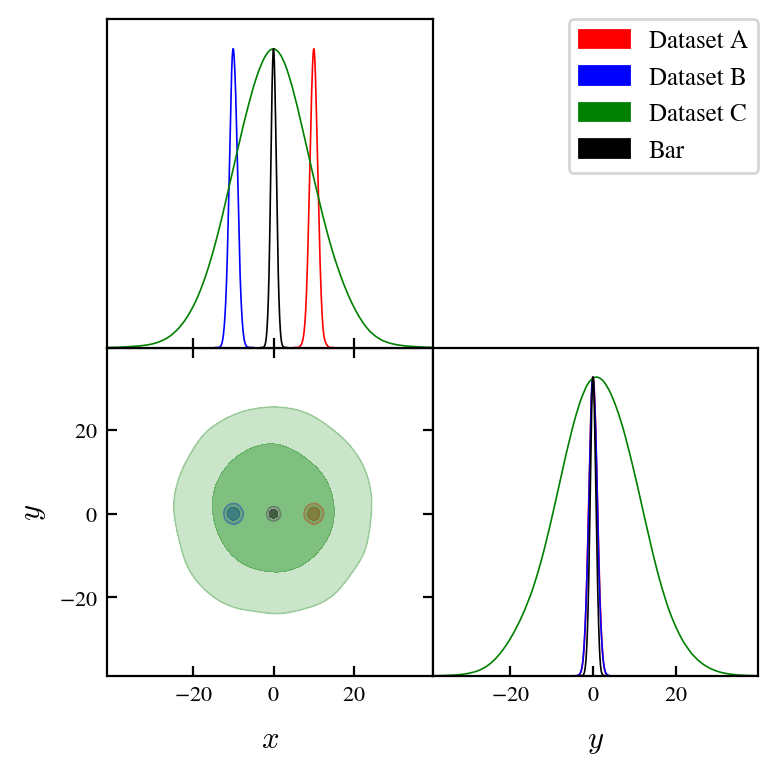

In [7]:
#Fixed Parameters
num_parameters = 2
num_datasets = 3

r=10

#Sharp triangle
theta_A = 0
theta_B = np.pi
theta_C = np.pi/2


#Sharp triangle
mean_A = r*np.array([np.cos(theta_A), np.sin(theta_A)]) 
mean_B = r*np.array([np.cos(theta_B), np.sin(theta_B)]) 
mean_C = np.array([np.cos(theta_C), np.sin(theta_C)]) 

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = 100*cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

#mean_bar = (mean_A + mean_B + mean_C)/num_datasets

cov_tot = cov_A + cov_B + cov_C
#cov_bar = cov_tot / num_datasets**2

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C], [cov_A, cov_B, cov_C])
mean_bar = centroid
cov_bar = centroid_covariance


delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar

samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
chain_bar = MCSamples(samples=samps_bar, names=names, labels=labels, label='Bar')

colors = ['red', 'blue', 'green', 'black']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_bar],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
#plt.savefig('triangle_plot_1_centroid.pdf')
